In [37]:
import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time
import os.path as path
from tensorflow import keras
import keras
import keras.backend as K

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import pickle
import numpy as np
from imutils import paths
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [ ]:

np.random.seed(2023)
EPOCHS = 150
BATCH_SIZE = 16 
CHANNELS = 1
num_classes = 5
img_height = 32
img_width = 32

In [39]:
def load_data(datasetPath):

    # load data from the pickle file
    with open(datasetPath, 'rb') as f:
        data, labels = pickle.load(f)


    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    print("\n[INFO] splitting dataset into train and validation sets")
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22)

    print("\n[INFO] reshaping images")
    x_train = x_train.reshape(x_train.shape[0], img_height, img_width, CHANNELS)
    x_test = x_test.reshape(x_test.shape[0], img_height, img_width, CHANNELS)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test



In [51]:
def build_model_1(MODEL_NAME):
    print("\n[INFO] creating model")
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(img_height, img_width, CHANNELS)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(50, (5, 5), padding="same", input_shape=(img_height, img_width, CHANNELS)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(100, (5, 5), padding="same", input_shape=(img_height, img_width, CHANNELS)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(20, 2)))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    return model



In [41]:
def build_model_2(MODEL_NAME):
    print("\n[INFO] creating model")
    model = Sequential()

    chanDim  = 1
    # first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(img_height, img_width, CHANNELS)))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3),  activation='relu', padding="same"))
    model.add(BatchNormalization(axis=chanDim))
        
    model.add(Conv2D(64, (3, 3),  activation='relu', padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [42]:
def LeNet5():
    model=Sequential()
    
    model.add(Conv2D(6,kernel_size=(5,5),strides=(1,1),activation='relu',input_shape=(img_height,img_width,CHANNELS),padding='same'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    
    model.add(Dense(84, activation='relu'))
    
    model.add(Dense(5, activation='softmax'))
    
    model.summary()
    return model

In [43]:
def plot_model_history(model_history,MODEL_NAME):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # print(model_history.history.keys())
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(len(model_history.history['accuracy']),10),np.arange(len(model_history.history['accuracy']),10))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(len(model_history.history['loss']),10),np.arange(len(model_history.history['loss']),10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    fig.savefig(f'./Model_graph/{MODEL_NAME}.png')



In [44]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


In [45]:
def train(model, x_train, y_train, x_test, y_test,MODEL_NAME):

    print("\n[INFO] model training starting\n")    
    model.compile(loss=keras.losses.categorical_crossentropy, \
                  optimizer=keras.optimizers.Adam(), \
                  metrics=['accuracy'])


    # start timer
    start = time.time()

    # checkpoint
    outputFolder = f'./output-checkpoint/{MODEL_NAME}'
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)

    filepath = outputFolder + "/weights-{epoch:02d}-{val_acc:.2f}.h5py"

    epoch_num = 50
    file_ini = outputFolder + '/weights-' + str(epoch_num) + '*'
    filename =  glob.glob(file_ini)
    K.set_value(model.optimizer.learning_rate, 0.0001)
    # checkpoint creation for saving model
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, \
                            save_best_only=False, save_weights_only=True, \
                            mode='auto', period=10)

    # tensorboard logs for visualization
    tbCallBack = TensorBoard(log_dir='./logs', batch_size=BATCH_SIZE, \
                write_grads=True, histogram_freq=2, write_graph=True, write_images=True)

    # define early stopping callback
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
    
    model_info = model.fit(x_train, y_train, \
            batch_size=BATCH_SIZE, \
            epochs=EPOCHS, \
            verbose=1, \
            validation_data=(x_test, y_test) , \
            callbacks=[tbCallBack])
    
    # end timer and print the time taken to train model
    end = time.time()
    print("\nModel took %0.2f seconds to train"%(end - start))
    # display graph accuracy and loss
    plot_model_history(model_info,MODEL_NAME)

    # compute test accuracy
    acc=accuracy(x_test, y_test, model)
    print("Accuracy on test data is: %0.2f"%acc)
    return acc




In [46]:
def export_model(model, MODEL_NAME):
    # Save trained model in .h5 file
    print("\n[INFO] exporting model to .h5 file")
    model.save(f"out/{MODEL_NAME}-{BATCH_SIZE}-{EPOCHS}.h5")
    print("\n[INFO] model saved")



In [47]:
def cnn_model_1():
    MODEL_NAME='CNN_model_1'
    model=build_model_1(MODEL_NAME)
    if not path.exists(f'out\\{MODEL_NAME}'):
        print("\n[info] out folder not available, creating folder 'out\MODEL NAME' in the root directory")
        os.mkdir(f'out\\{MODEL_NAME}')
    acc=train(model, x_train, y_train, x_test, y_test,MODEL_NAME)
    Accuracy[MODEL_NAME]=acc
    export_model(model, MODEL_NAME)

In [48]:
def cnn_model_2():
    MODEL_NAME='CNN_model_2'
    model=build_model_2(MODEL_NAME)
    if not path.exists(f'out\\{MODEL_NAME}'):
        print("\n[info] out folder not available, creating folder 'out\MODEL NAME' in the root directory")
        os.mkdir(f'out\\{MODEL_NAME}')
    acc=train(model, x_train, y_train, x_test, y_test,MODEL_NAME)
    Accuracy[MODEL_NAME]=acc
    export_model(model, MODEL_NAME)

In [49]:
def Lenet_model():
    MODEL_NAME='LeNET-5'
    model=LeNet5()
    if not path.exists(f'out\\{MODEL_NAME}'):
        print("\n[info] out folder not available, creating folder 'out\MODEL NAME' in the root directory")
        os.mkdir(f'out\\{MODEL_NAME}')
    acc=train(model, x_train, y_train, x_test, y_test,MODEL_NAME)
    Accuracy[MODEL_NAME]=acc
    export_model(model, MODEL_NAME)


[INFO] loading data from the dataset into variables

[INFO] splitting dataset into train and validation sets

[INFO] reshaping images

[INFO] creating model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 20)        520       
                                                                 
 activation_10 (Activation)  (None, 32, 32, 20)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 20)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 20)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 50)        25050     
                            

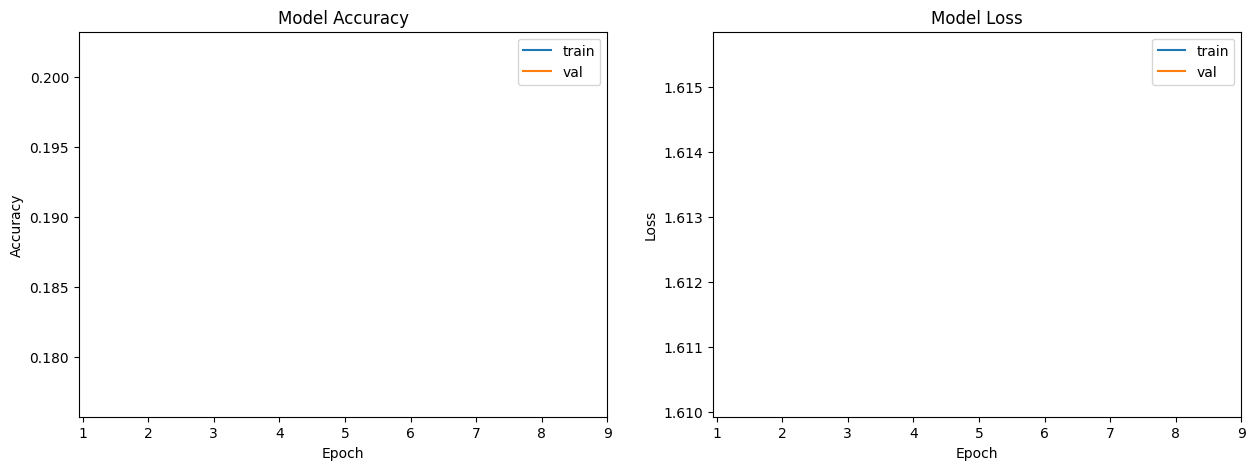

8/8 [==============================] - 0s 36ms/step
Accuracy on test data is: 17.70

[INFO] exporting model to .h5 file

[INFO] model saved

[INFO] creating model


C:\Users\sharm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



[info] out folder not available, creating folder 'out\MODEL NAME' in the root directory

[INFO] model training starting

57/57 [==============================] - 19s 269ms/step - loss: 2.4690 - accuracy: 0.1964 - val_loss: 1.8487 - val_accuracy: 0.2124

Model took 19.19 seconds to train


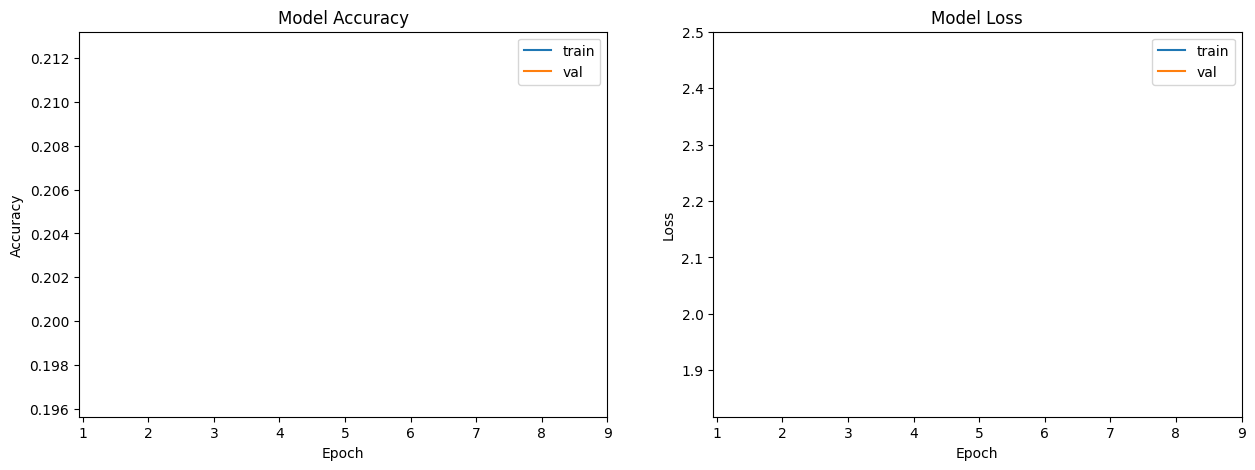

8/8 [==============================] - 1s 76ms/step
Accuracy on test data is: 21.24

[INFO] exporting model to .h5 file

[INFO] model saved


NameError: name 'Lenetmodel' is not defined

In [53]:
Accuracy=dict()

print("\n[INFO] loading data from the dataset into variables")
x_train, y_train, x_test, y_test = load_data("dataset_pickles\dataset_classes.pickle")
cnn_model_1()
cnn_model_2()
Lenet_model()

In [ ]:
fig = plt.figure()
plt.bar(Accuracy.keys(),Accuracy.values(),color=[0.2,0.4,0.6,0.6])
plt.title('Accuracy Comparison Chart')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0,,100)
plt.show()


In [21]:
print("Saving Chart in image format")
fig.savefig('Comparison chart.jpeg')